# V2 : NON-LEARNABLE SPATIAL ESTIMATOR

### Datasets used for this version :
    - BUILT-H - ghsl 
    - BUILT-V - ghsl (for assertion)
    - MS Buildings

In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import rasterio
import numpy as np
import pickle
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import shapely
from to_degree import to_degree
from region_new import Region

In [2]:
# bounding boxes and FUA's
bounding_box = json.load(open('bounding_box.json'))

In [3]:
height_path = os.path.join('data', 'ghsl', 'height', '')
volume_path = os.path.join('data', 'ghsl', 'volume', '')

In [4]:
# # house data
# ordu_house = os.path.join("data","clipped_house","Ordu_house.pkl")
# johannesburg_house = os.path.join("data","clipped_house","Johannesburg_house.pkl")
# cairo_house = os.path.join("data","clipped_house","Cairo_house.pkl")
# manisa_house = os.path.join("data","clipped_house","Manisa_house.pkl")
# adana_house = os.path.join("data","clipped_house","Adana_house.pkl")
# trabzon_house = os.path.join("data","clipped_house","Trabzon_house.pkl")

johannesburg_house = os.path.join("data","microsoft_buildings","Johannesburg.json")
cairo_house = os.path.join("data","microsoft_buildings","Cairo.json")
adana_house = os.path.join("data","microsoft_buildings","Adana.json")

In [5]:
cities = dict(
    Adana = dict(
        box= bounding_box["Adana"]["box"],
        fua= bounding_box["Adana"]["fua"],
        name = "Adana",
        house = adana_house
    ),
    Cairo = dict(
        box= bounding_box["Cairo"]["box"],
        fua= bounding_box["Cairo"]["fua"],
        name = "Cairo",
        house = cairo_house
    ),
    Johannesburg = dict(
        box= bounding_box["Johannesburg"]["box"],
        fua= bounding_box["Johannesburg"]["fua"],
        name = "Johannesburg",
        house = johannesburg_house
    ),
)

In [6]:
# Reproject GHSL Data into EPSG:4326
to_degree(height_path, cities)
to_degree(volume_path, cities)

In [6]:
Cities = {}
resolution = (-500, 500)
# resolution = (-100, 100)
for index, (key, val) in enumerate(cities.items()):
    print(key)
    box, fua, name, house = val["box"], val["fua"], val["name"], val["house"]
    city = Region(val["box"])


    # Parse FUA edges from JSON
    fua = shapely.geometry.Polygon(fua)
    fua = geopandas.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[fua])
    # FUA edges
    city.add_layer(layer_name="fua", 
                   geo_data=fua, 
                   layer_type="vector", 
                   box=box, 
                   meta="Functional Urban Area")
    
    # MS building
    house = geopandas.read_file(house)
    house['density']=1
    house = house.to_crs("EPSG:3395")
    house['area']= house["geometry"].area
    house = house.to_crs("EPSG:4326")
    city.add_layer(layer_name="MS", 
                   geo_data=house, 
                   layer_type="vector", 
                   meta="MS buildings")
   
    # GHSL Layers
    city.add_layer(layer_name="volume", 
                   geo_data=volume_path+name+'.tif', 
                   layer_type="raster", 
                   box=box, 
                   var_name="volume", 
                   meta="GHSL BUILT-V")

    city.add_layer(layer_name="height", 
                   geo_data=height_path+name+'.tif', 
                   layer_type="raster", 
                   box=box, 
                   var_name="height", 
                   meta="GHSL BUILT-H")
    
    # convert vector to raster
    city.add_raster_from_vector(layer_name="MS", 
                                measurements=["area","density"], 
                                resolution=resolution, 
                                new_name = "MS_raster",
                                res_type="meter")
    # unify the projection
    city.unify_proj(crs_type="meter")
    
    # merge raster as output xarray
    city.merge_data(base_raster="MS_raster", 
                    raster_list={
                        "height":(["height"], "linear"),
                        "volume": (["volume"], "linear")
                        }
                    )
    
    # estimate co2 emission with simple function
    city.output = city.output.assign(emission = emission_nlse)
    Cities[key] = city           
    print(city.output)                                                                       

Johannesburg
<xarray.Dataset>
Dimensions:      (x: 210, y: 180, band: 1)
Coordinates:
  * x            (x) float64 3.069e+06 3.07e+06 3.07e+06 ... 3.173e+06 3.174e+06
  * y            (y) float64 -2.953e+06 -2.954e+06 ... -3.042e+06 -3.043e+06
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    area         (y, x) float64 0.0 0.0 0.0 0.0 1.716e+03 ... 0.0 0.0 0.0 0.0
    density      (y, x) float64 0.0 0.0 0.0 0.0 3.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    height       (band, y, x) float64 nan 0.0 0.0 0.0 0.0 ... nan nan nan nan
    volume       (band, y, x) float64 nan 0.0 0.0 0.0 0.0 ... nan nan nan nan
    emission     (y, x, band) float64 nan 0.0 0.0 0.0 0.0 ... nan nan nan nan


In [19]:
# dump city
dump_path = os.path.join("data","Cities_v2_nlse.pickle")
with open(dump_path,"wb") as f:
    pickle.dump(Cities, f, protocol=pickle.HIGHEST_PROTOCOL)

## RESULTS

In [6]:
# load city
dump_path = os.path.join("data","Cities_v2_nlse.pickle")
with open(dump_path, 'rb') as f:
    Cities = pickle.load(f)

In [7]:
cairo = Cities['Cairo']
adana = Cities['Adana']
johannesburg = Cities['Johannesburg']

### ADANA

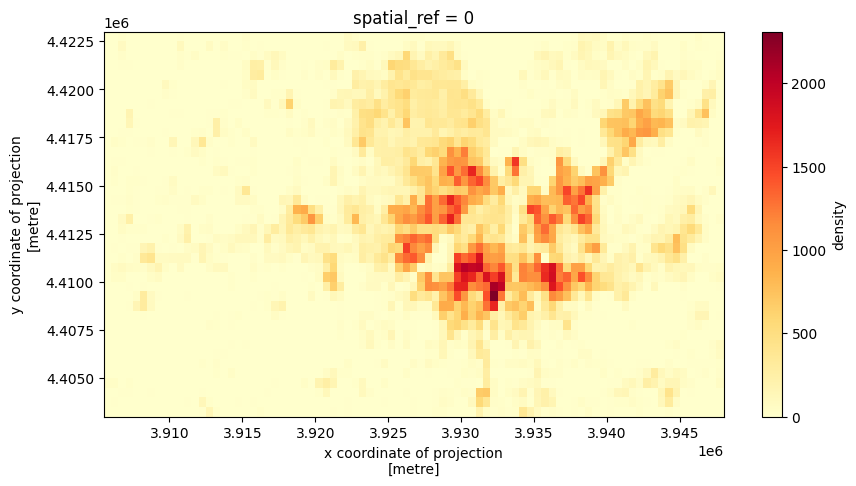

In [8]:
# BUILDING DENSITY
adana.output.density.plot(cmap="YlOrRd", figsize=(10,5))

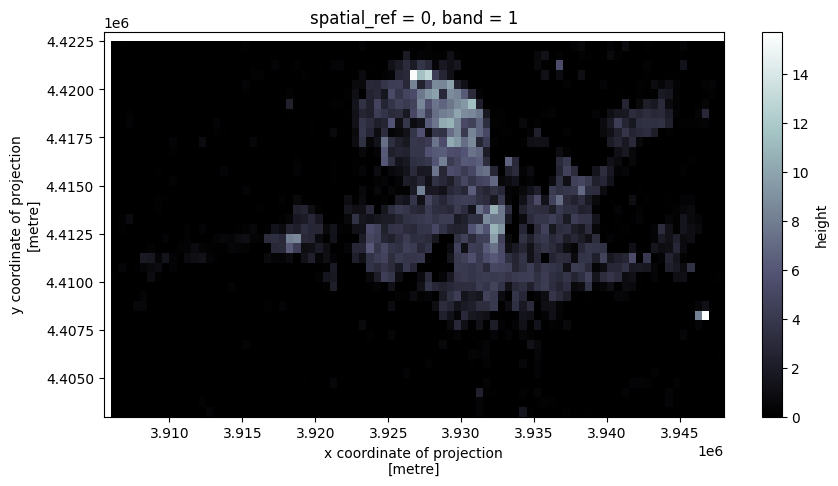

In [9]:
# BUILDING HEIGHT
adana.output.height.plot(cmap="bone", figsize=(10,5))

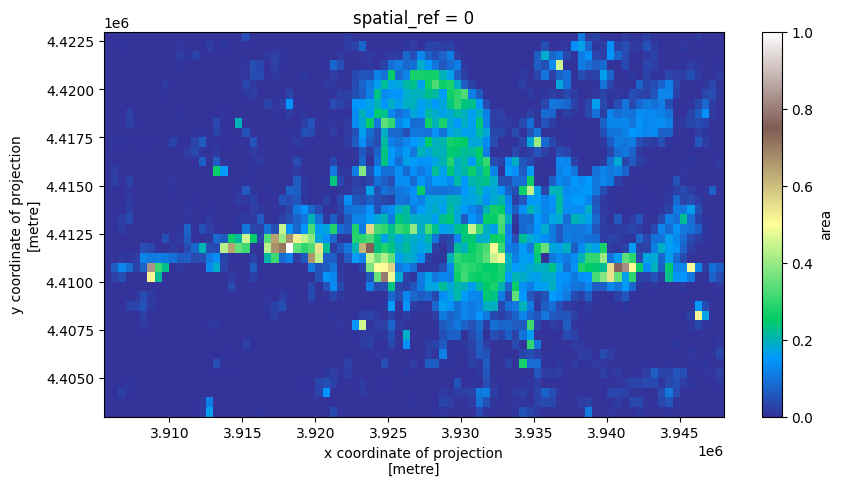

In [20]:
# AREA
adana.output.area.plot(cmap='terrain', figsize=(10,5))

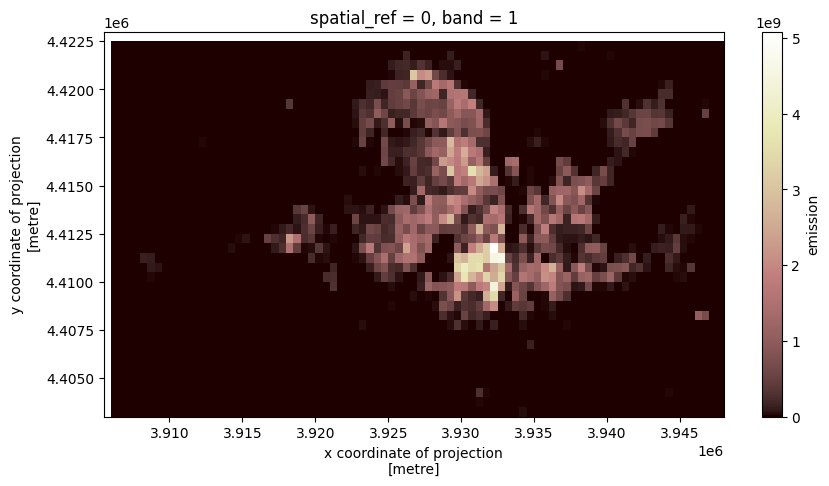

In [11]:
# Emission weights 
adana.output.emission.plot(cmap="pink",figsize=(10,5))

### CAIRO

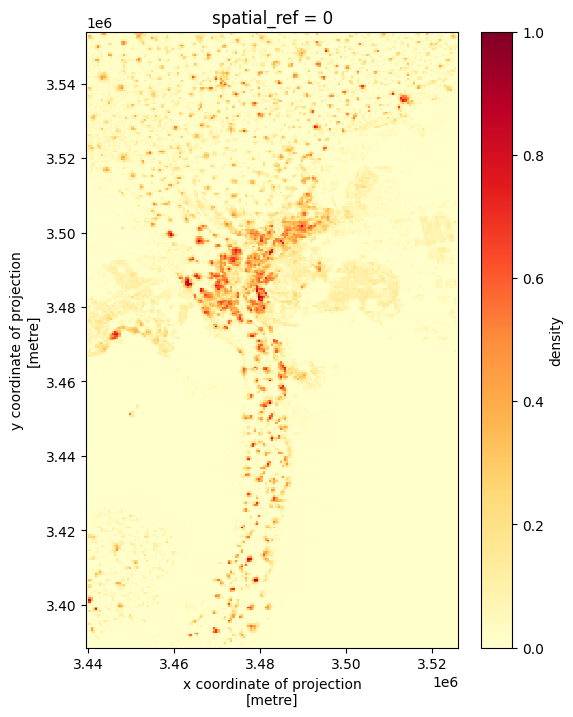

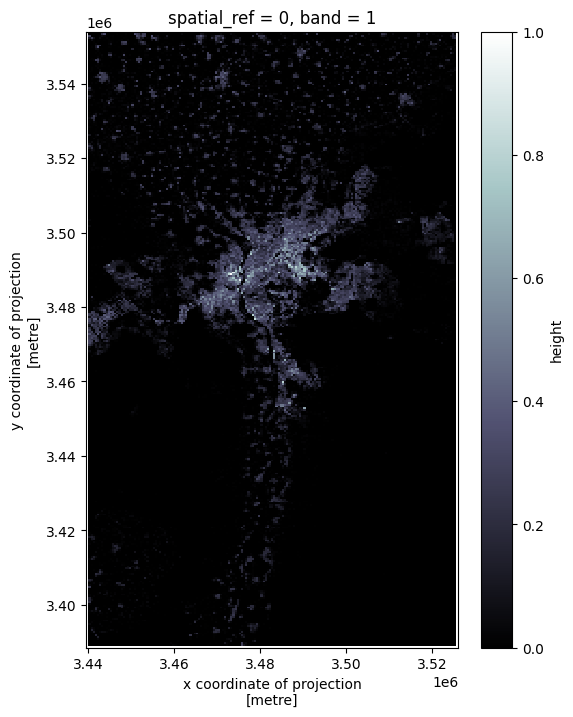

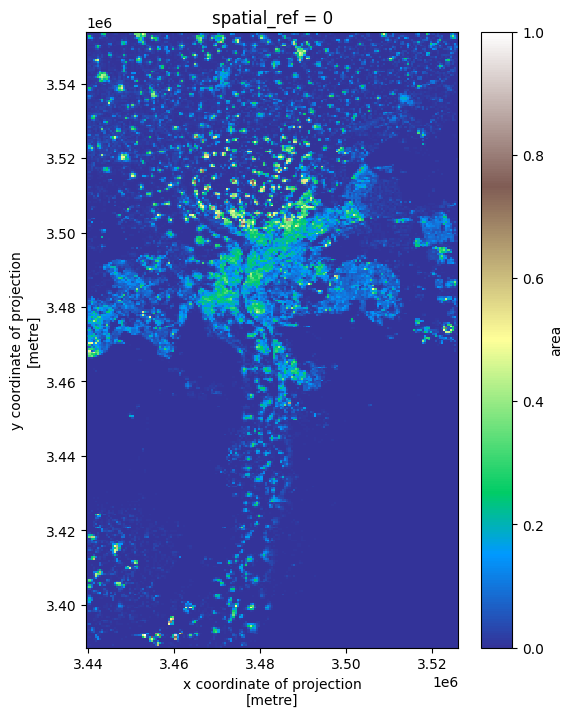

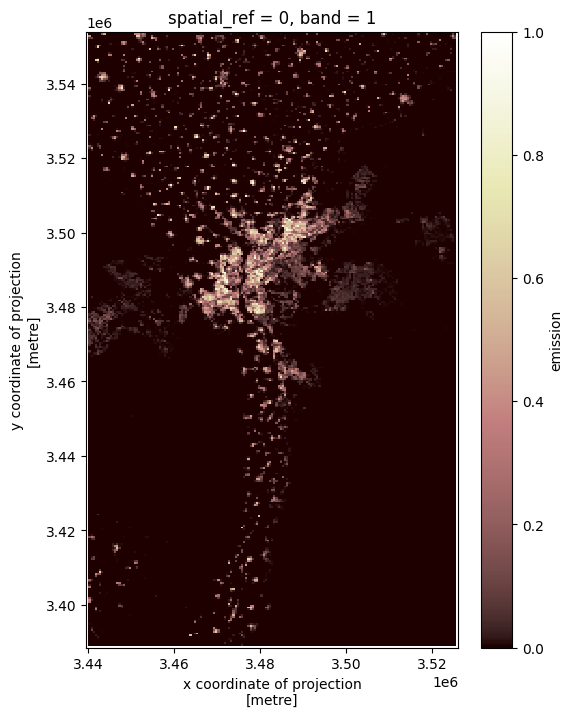

In [21]:
# BUILDING DENSITY
cairo.output.density.plot(cmap="YlOrRd", figsize=(6,8))
# HEIGHT
cairo.output.height.plot(cmap="bone", figsize=(6,8))
# AREA
cairo.output.area.plot(cmap="terrain", figsize=(6,8))
# EMISSION
cairo.output.emission.plot(cmap="pink", figsize=(6,8))

### JOHANNESBURG

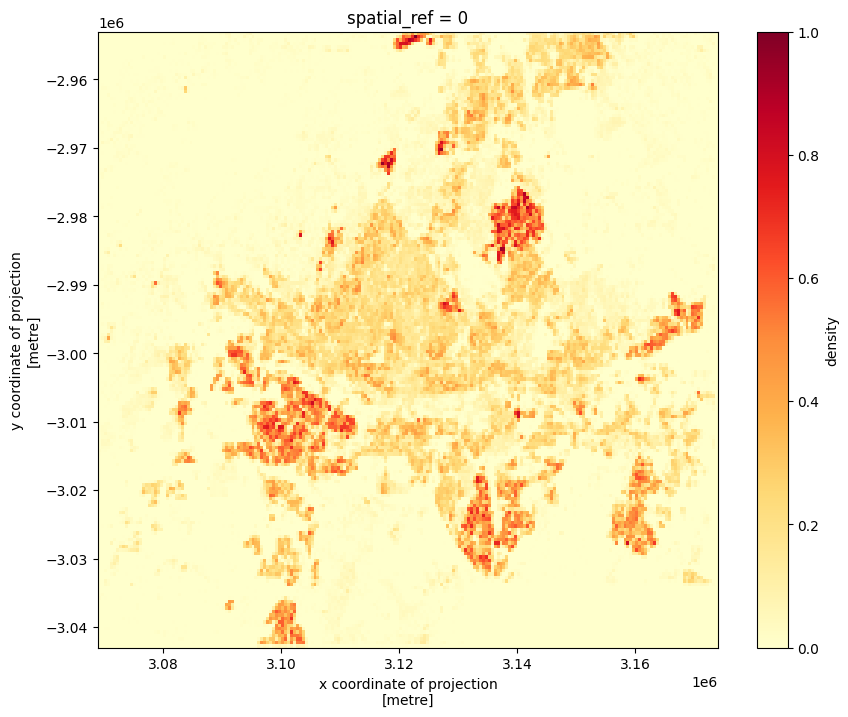

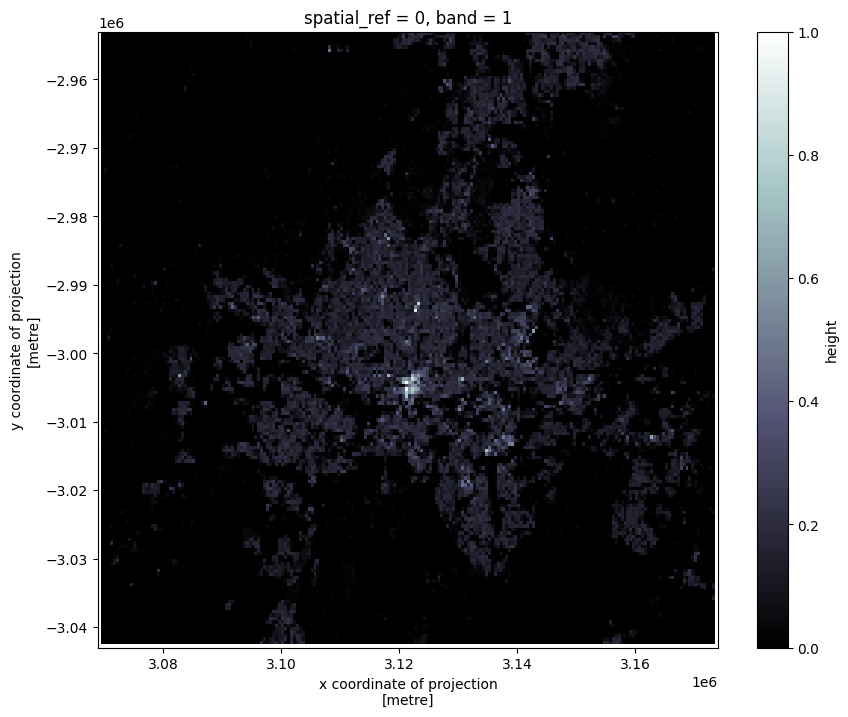

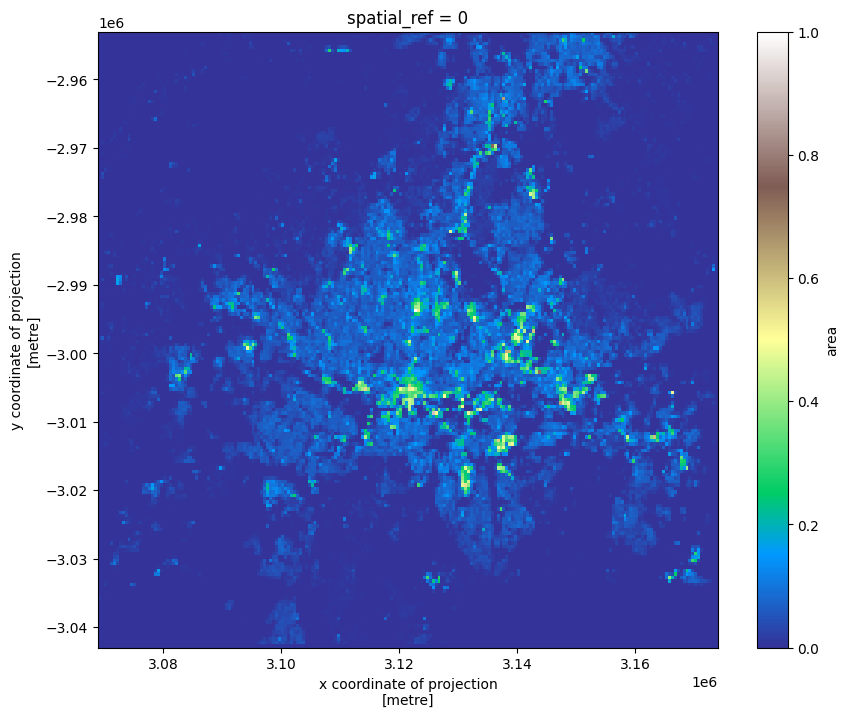

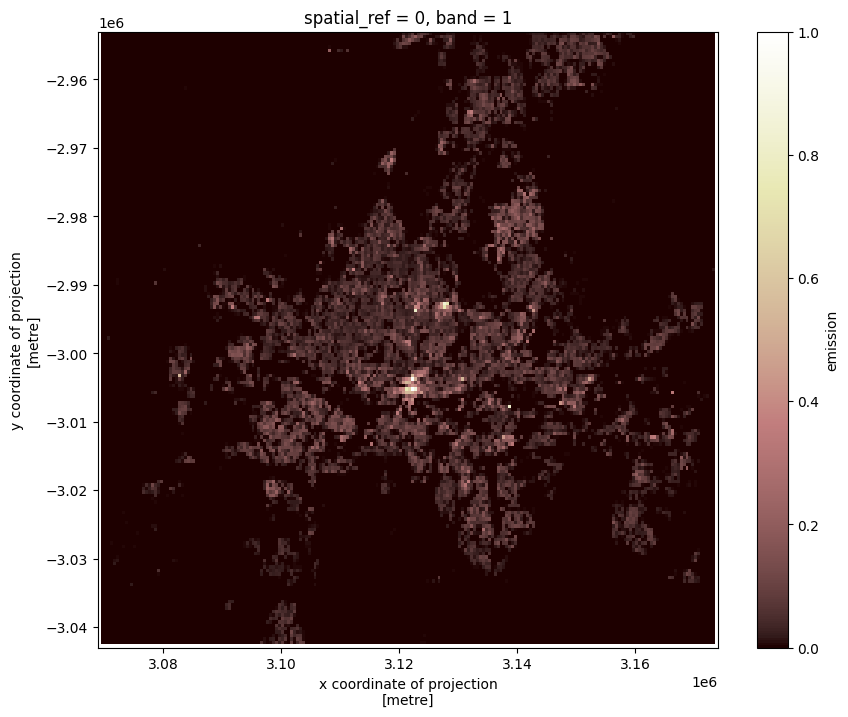

: 

In [22]:
# BUILDING DENSITY
johannesburg.output.density.plot(cmap="YlOrRd", figsize=(10,8))
# HEIGHT
johannesburg.output.height.plot(cmap="bone", figsize=(10,8))
# AREA
johannesburg.output.area.plot(cmap="terrain", figsize=(10,8))
# EMISSION
johannesburg.output.emission.plot(cmap="pink", figsize=(10,8))

### DISPLAY TIFF RESULTS

In [17]:
# Write Results as TIF
result_path = os.path.join('data', 'results', '')
adana.output.emission.transpose('band','y', 'x').rio.to_raster(result_path+'adana.tif')
cairo.output.emission.transpose('band','y', 'x').rio.to_raster(result_path+'cairo.tif')
johannesburg.output.emission.transpose('band','y', 'x').rio.to_raster(result_path+'johannesburg.tif')

In [18]:
import xarray as xr
result_path = os.path.join('data', 'results', '')
city = 'adana'
result = xr.open_dataset(result_path+city+'.tif')

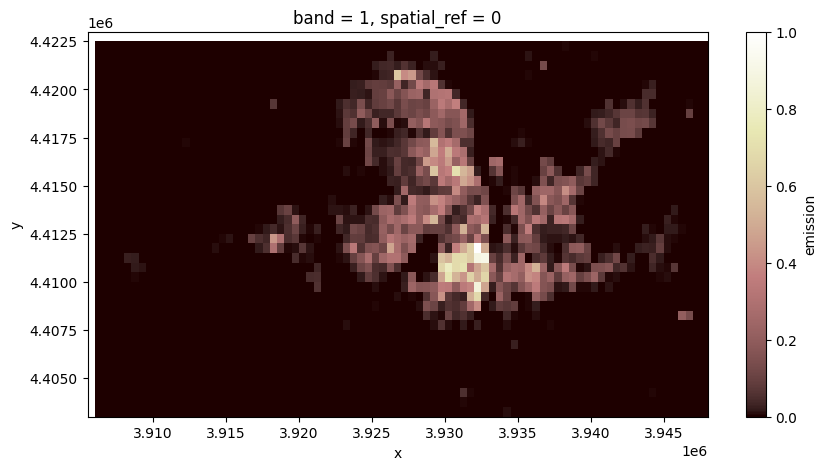

In [19]:
result.band_data.plot(cmap="pink", figsize=(10,5))

#### Some illustrative difference map :
    - GHSL volume vs our (area * height) volume

In [8]:
adana.output = adana.output.assign(volume_calc = adana.output.height * adana.output.area)

In [9]:
adana.normalize_output()
johannesburg.normalize_output()
cairo.normalize_output()

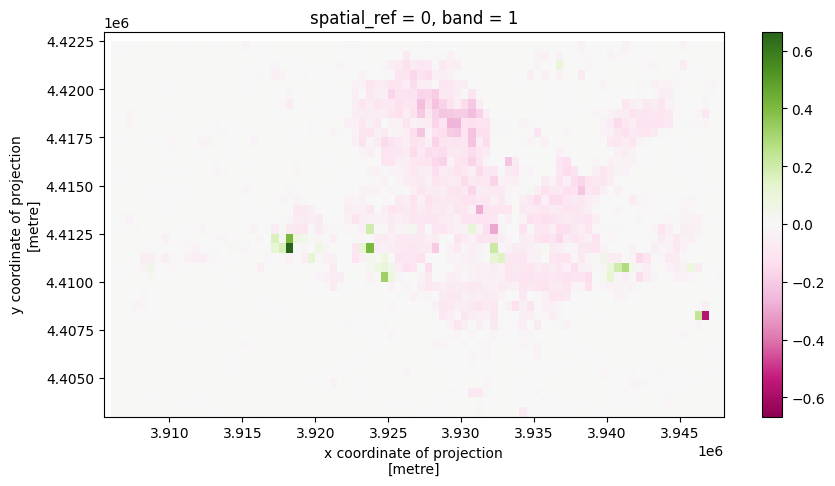

In [12]:
adana.difference_map('volume_calc', 'volume')


We tend to very slightly underestimate the volume compared to the GHSL estimation.  
It is worth noting that major differences in volumes seem to concern industrial areas (green = warehouses, parking lots / purple = factories)